<a href="https://colab.research.google.com/github/michalis0/Business-Intelligence-and-Analytics/blob/master/Assignment/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
import statistics

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

warnings.filterwarnings('ignore')
%matplotlib inline

<div>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Logo_Universit%C3%A9_de_Lausanne.svg/2000px-Logo_Universit%C3%A9_de_Lausanne.svg.png" style="padding-right:10px;width:240px;float:left"/></td>
<h2 style="white-space: nowrap">Business Intelligence and Analytics Personal Assignment</h2></td>
<hr style="clear:both">
<p style="font-size:0.85em; margin:2px; text-align:justify">

</div>

# IMPORTANT

Question 1: Before starting this assignment, please indicate whether this course is worth 4.5 or 6 credits to you. Please answer truthfully, as checks will be made afterwards. This question is only intended to facilitate the calculation of final points.

> TODO: Your answer here

# Part 1: Climate Analytics - Rice vs Wheat in a Changing World

## Context

You work as a junior data analyst at SerriFleur, an international NGO focused on sustainable agriculture in the face of climate change. Your team is investigating how climate conditions and farming practices affect the yields of rice and wheat — two of the most critical staple crops globally.

You’ve just received a massive dataset from the research division: "Hydroponix.csv". Your task is to extract insights, build models, and tell a compelling story from the data. You can find the dataset here: https://media.githubusercontent.com/media/michalis0/Business-Intelligence-and-Analytics/refs/heads/master/data/Hydroponix.csv

Columns Overview:

* `Year` : Year of the observation.

* `Country` : Country where the data was collected.

* `Region` : Specific region within the country.

* `Crop_Type` : Type of agricultural crop observed.

* `Average_Temperature` : Annual average temperature in degrees Celsius.

* `Total_Precipitation` : Total annual precipitation in millimeters.

* `CO2_Emissions` : CO₂ emissions in million tons.

* `Crop_Yield` : Agricultural yield in tons per hectare.

* `Extreme_Weather_Events` : Number of recorded extreme weather events.

* `Irrigation_Access` : Percentage of cultivated land with access to irrigation.

* `Pesticide_Use` : Pesticide use in kilograms per hectare.

* `Fertilizer_Use` : Fertilizer use in kilograms per hectare.

* `Soil_Health_Index` : Soil quality index (out of 100).

* `Economic_Impact` : Economic impact in million USD.

In [2]:
data_climate = pd.read_csv("https://media.githubusercontent.com/media/michalis0/Business-Intelligence-and-Analytics/refs/heads/master/data/Hydroponix.csv")

## Exercise 1: Data Cleaning & Preprocessing



The dataset you’ve received contains data from multiple countries, various crops, and inconsistent formatting. Your first job is to narrow the scope of your study and prepare a clean dataset that’s ready for analysis.

Your mission:

*   Filter the dataset to focus only on rice and wheat
*   Drop the regional identifiers column
*   Group the data by Country, Year and Crop_type but don't put them as index (*Hint: specific parameter of `groupby`*) and calculate the mean of each column
*   Change the type of the columns `Country` and `Crop_type`


In [3]:
# Question 2: Find the list of crop types produced by SerriFleur

crop_types =  list(data_climate['Crop_Type'].unique())

In [4]:
# Data cleaning

cleaned_data = data_climate[(data_climate['Crop_Type'] == 'Rice') | (data_climate['Crop_Type']== 'Wheat')]
cleaned_data = cleaned_data.drop('Region', axis=1)
cleaned_data = cleaned_data.groupby(['Country', 'Year', 'Crop_Type'], as_index=False).mean()
cleaned_data = cleaned_data.astype({'Country': 'string', 'Crop_Type': 'string'})

In [5]:
# Question 3: Find the total number of countries where Serrifleur operates in

len(cleaned_data['Country'].unique())

10

**Note on Climate Variables per Crop**:

> You may notice that climate-related variables such as average temperature and total precipitation vary across different crops, even for the same country and year. This is because each crop is typically grown in different regions within a country, depending on factors like soil conditions, irrigation availability, and climatic suitability. For example, wheat might be cultivated in cooler northern regions while corn is grown in warmer southern areas. Therefore, the recorded climate data reflects regional conditions specific to where each crop is grown, rather than national averages. This is an important consideration when interpreting the results of this analysis.

## Exercise 2: Exploratory Data Analysis

Before diving into modeling, your supervisor wants a clear picture of the current state of affairs in South America. You’re tasked with visualizing total precipitation level, economic impacts and soil health.

Your mission:


*   Plot total precipitation evolution over the years for each crop in Argentina
*   Create a pie chart that shows the percentage share of the total economic impact for each crop in Brazil
*   Create boxplots comparing soil health across crops and all the countries


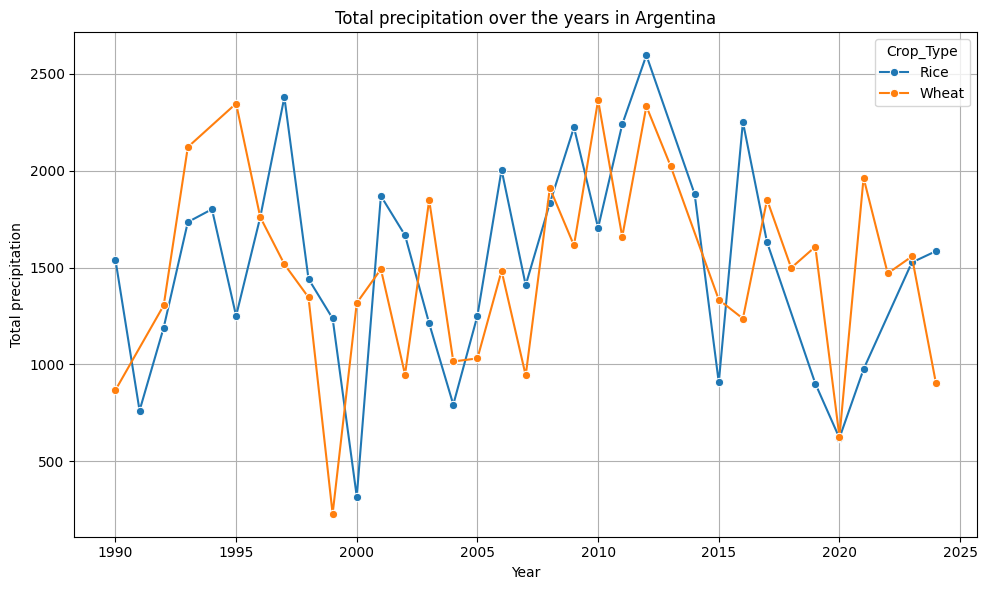

In [6]:
# Question 4: Create the graph of the total precipitation evolution over the years for each crop in Argentina

data_argentina = cleaned_data[cleaned_data['Country']=='Argentina']

plt.figure(figsize=(10, 6))
sns.lineplot(data=data_argentina, x='Year', y='Total_Precipitation', hue='Crop_Type', marker='o')
plt.title('Total precipitation over the years in Argentina')
plt.ylabel('Total precipitation')
plt.grid(True)
plt.tight_layout()
plt.show()

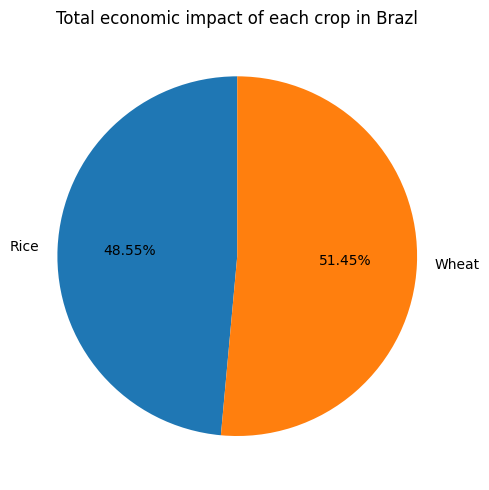

In [7]:
# Question 5: Create the pie chart that shows the percentage share of the totale economic impact for each crop in Brazil

brazil_data = cleaned_data[cleaned_data['Country'] == 'Brazil']
brazil_economic_impact = brazil_data.groupby('Crop_Type')['Economic_Impact'].sum()

plt.figure(figsize=(5, 5))
plt.pie(brazil_economic_impact, labels=brazil_economic_impact.index, autopct='%1.2f%%', startangle=90)
plt.title('Total economic impact of each crop in Brazl')
plt.axis('equal')
plt.tight_layout()
plt.show()

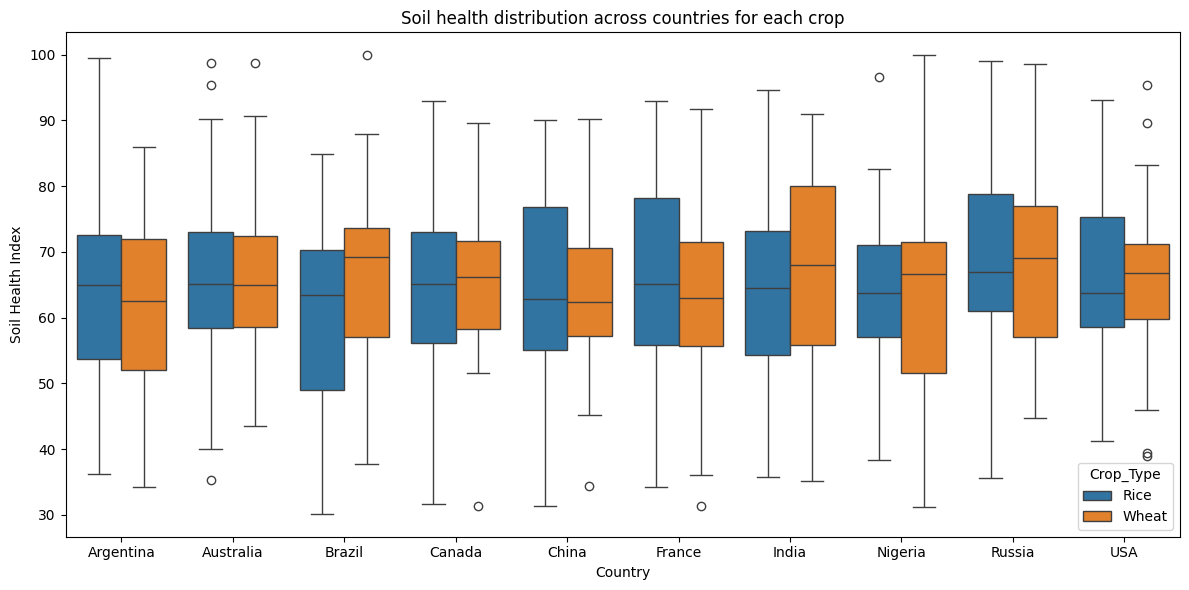

In [8]:
# Question 6: Create the boxplots that compare the soil health index across crops and all the countries

plt.figure(figsize=(12, 6))
sns.boxplot(cleaned_data, x='Country', y='Soil_Health_Index', hue='Crop_Type')
plt.title('Soil health distribution across countries for each crop')
plt.ylabel('Soil Health Index')
plt.xlabel('Country')
plt.tight_layout()
plt.show()

## Exercise 3: Clustering

SerriFleur aims to classify countries based on their farming practices in order to provide region-specific recommendations. You propose using unsupervised learning to identify distinct fertilizer usage profiles.

Your mission:



*   For each crop type, use agglomerative clustering on fertilizer usage with 4 clusters, euclidian distance metric and ward linkage
*   Analyze whether wheat and rice follow similar cluster pattern
*   Plot the dendrogram representation of fertilizer usage, for each crop type, with euclidian distance metric and average linkage


In [9]:
# Agglomerative Clustering for Wheat
# Question 7: Find the number of values in each clustering label

wheat = cleaned_data[cleaned_data['Crop_Type'] == 'Wheat'].drop(columns=['Country', 'Crop_Type'])

model = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
prediction = model.fit_predict(pd.DataFrame(wheat['Fertilizer_Use']))

unique, counts = np.unique(prediction, return_counts=True)

for cluster, count in zip(unique, counts):
  print(f"In cluster {cluster} there is {count} values")

In cluster 0 there is 129 values
In cluster 1 there is 126 values
In cluster 2 there is 34 values
In cluster 3 there is 44 values


In [10]:
# Agglomerative Clustering for Rice
# Question 7: Find the number of values in each clustering label

rice = cleaned_data[cleaned_data['Crop_Type'] == 'Rice'].drop(columns=['Country', 'Crop_Type'])

model = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
prediction = model.fit_predict(pd.DataFrame(rice['Fertilizer_Use']))

unique, counts = np.unique(prediction, return_counts=True)
for cluster, count in zip(unique, counts):
  print(f"In cluster {cluster} there is {count} values")


In cluster 0 there is 137 values
In cluster 1 there is 50 values
In cluster 2 there is 60 values
In cluster 3 there is 85 values


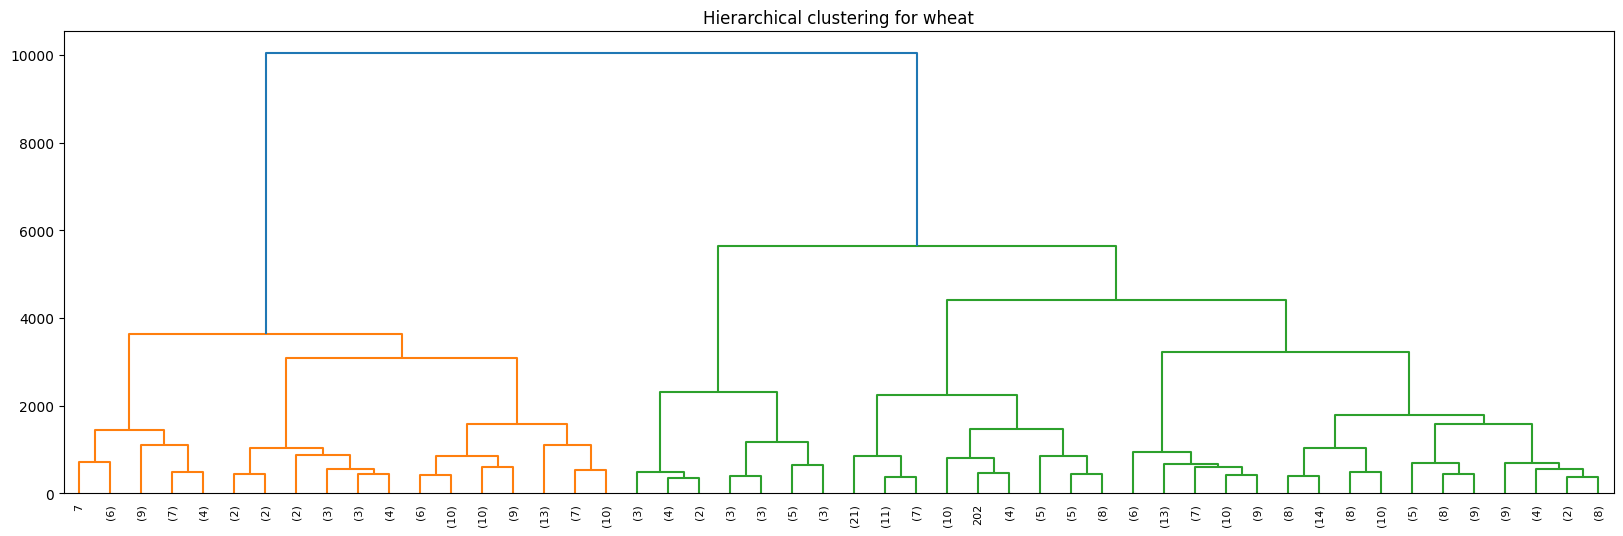

In [11]:
# Question 8: Hierarchical Clustering for Wheat
# Don't forget to reshape the values with numpy

linkage_matrix = linkage(wheat, metric='euclidean', method='ward')

plt.figure(figsize=(20, 6))
dendrogram(linkage_matrix, p=50, truncate_mode='lastp')
plt.title('Hierarchical clustering for wheat')
plt.show()

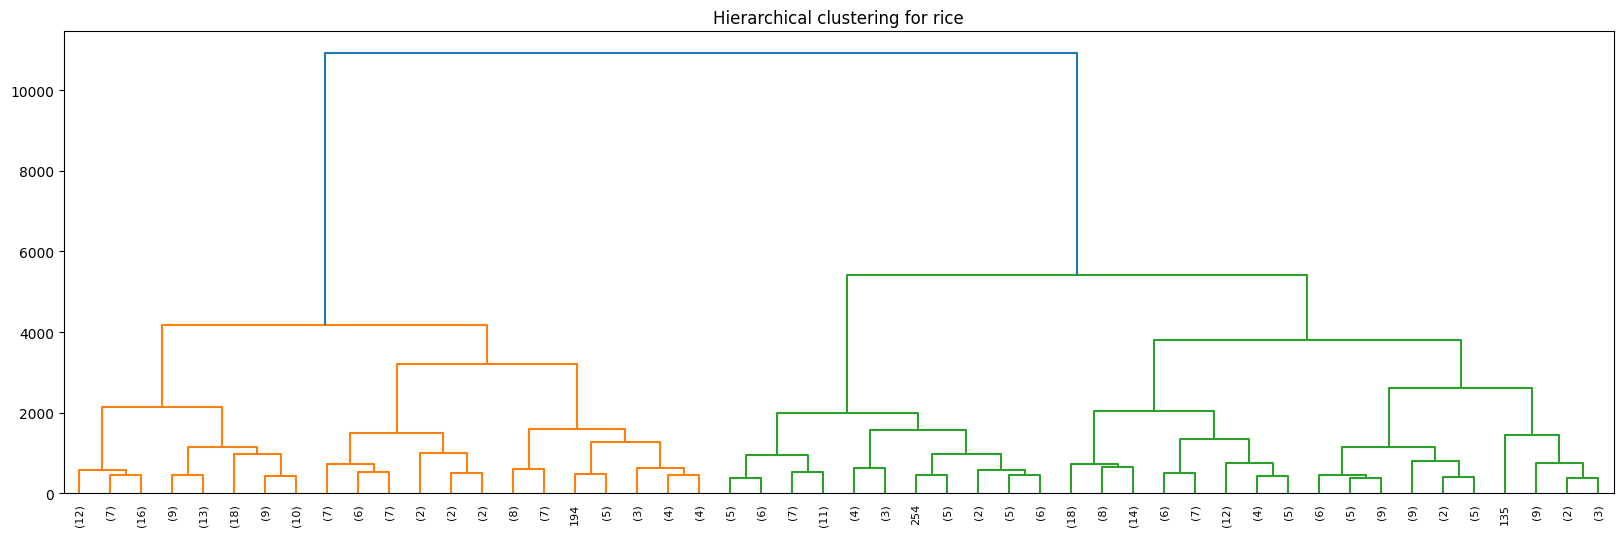

In [12]:
# Question 8: Hierarchical Clustering for Rice
# Don't forget to reshape the values with numpy

linkage_matrix = linkage(rice, metric='euclidean', method='ward')

plt.figure(figsize=(20, 6))
dendrogram(linkage_matrix, p=50, truncate_mode='lastp')
plt.title('Hierarchical clustering for rice')
plt.show()

## Exercise 4: Simple Linear Regression

A policymaker asks a simple question: "Does CO₂ have a measurable impact on crop yield for wheat and rice ?"
You decide to test this using a basic regression model.

Your mission:

*   Plot the heatmap of correlations for numeric columns only.
*   Model Crop_Yield as a function of CO2_Emissions (with `test_size = 0.3`, `random_state = 123` and `shuffle=True`).
*   Use MinMaxScaler and find the $R^2$, the MSE and the MAE.






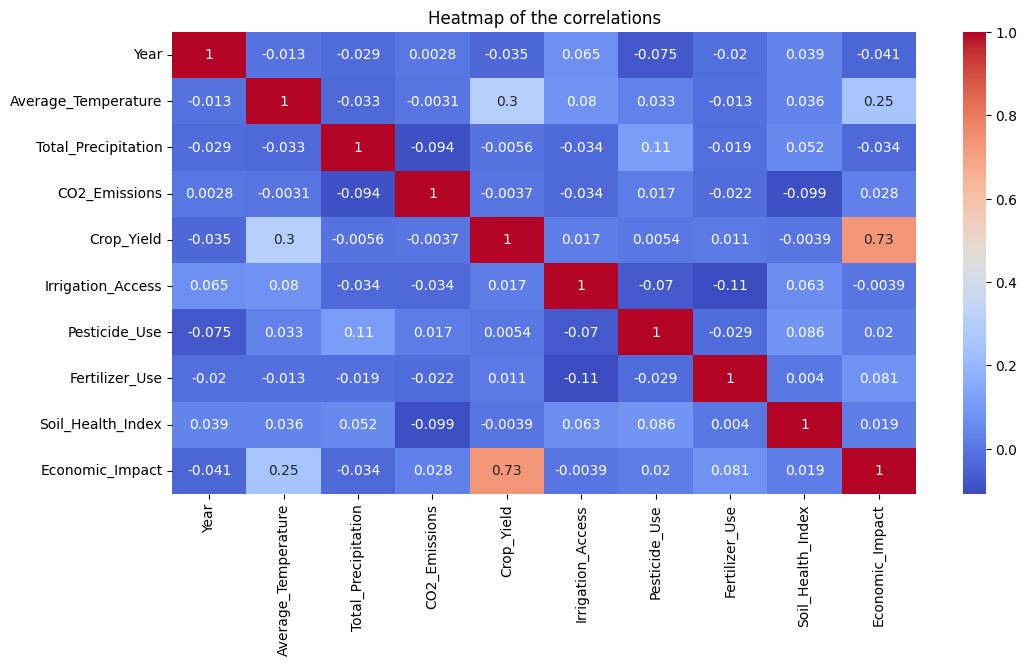

In [13]:
# Question 9: Plot heatmap of correlations

corr = cleaned_data.select_dtypes(include=['number']).corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Heatmap of the correlations')
plt.show()

In [14]:
# Seperate features and labels
X = cleaned_data[['CO2_Emissions']]
y = cleaned_data[['Crop_Yield']]

In [15]:
# Split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, shuffle=True)

In [16]:
# Scale the data

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# Create linear regression model and fit into the training data

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [18]:
# Question 10: Print out the R2, MSE and MAE score

predictions = model.predict(X_test)

R2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f"R squared : {R2:.4f}")
print(f"Mean absolute error : {mae:.4f}")
print(f"Mean square error : {mse:.4f}")

R squared : -0.0084
Mean absolute error : 0.5525
Mean square error : 0.4784


## Exercise 5: Multivariate Regression with Categorical Variables

Real-life relationships are rarely one-dimensional. You now create a new model to include all the other variables of the dataset, some of which are key climate factors.

Your mission:


*   Transform the column `Crop_Type` using `LabelEncoder`function and the column `Country` using `One-Hot` encoding
*   Build a multivariate regression model using all the variables to predict crop yield  (with `test_size = 0.3`, `random_state = 123` and `shuffle=True`)
*   Compare its performance with the previous model of part 4



In [19]:
# Seperate features and labels, and transform the columns Crop_Type and Country (don't forget to delete the old columns)

label_encoder = LabelEncoder()
cleaned_data['Crop_Type'] = label_encoder.fit_transform(cleaned_data['Crop_Type'])

dummies = pd.get_dummies(cleaned_data['Country'], dtype=int)
one_hot_data = pd.concat([cleaned_data, dummies], axis=1)
del one_hot_data['Country']

label_column = ['Crop_Yield']
X = one_hot_data.drop(columns=label_column)
y = one_hot_data[label_column]

In [20]:
# Split data into train and test sets, create linear regression model and fit into the training data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, shuffle=True)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [21]:
# Question 11: Print out the R2, MSE and MAE score

predictions = model.predict(X_test)

R2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f"R squared : {R2:.4f}")
print(f"Mean absolute error : {mae:.4f}")
print(f"Mean square error : {mse:.4f}")

R squared : 0.5377
Mean absolute error : 0.3779
Mean square error : 0.2193


# Part 2: Association Rules - Turn movies ratings into bussiness insights!

Lights, Camera, Data!

Are you a movie fan? I bet you are! Have you ever wondered how streaming platforms like Netflix seem to know exactly which movie you'll love next? You might have heard that they use recommendation algorithms and wondered how they work.

In this assignment, you'll explore how **association rules** can be used to develop a simple recommendation algorithm. The idea is simple: by analyzing which movies are frequently watched together, we can uncover patterns and use these insights to suggest movies based on a user's viewing history.

Now, let's dive in and make it happen!

## Exercise 1: Data Processing

We will use a subset of MoviesLens dataset, which consists of user ratings for a list of movies and information about the movies themselves (i.e., title and genres).

First, you need to load the ratings data from the URL below, and try to print out the size of the dataset, the number of users who provided ratings, and the number of movies that have been rated.

URL = "https://media.githubusercontent.com/media/michalis0/Business-Intelligence-and-Analytics/refs/heads/master/data/ml/ratings.csv"

The `ratings` dataset contains four columns:

- `userID`: The ID of the user.
- `movieID`: The ID of the movie being rated.
- `rating`: The rating given by the user for the corresponding movie.
- `timestamp`: The timestamp when the rating was recorded.

In [22]:
df_ratings = pd.read_csv("https://media.githubusercontent.com/media/michalis0/Business-Intelligence-and-Analytics/refs/heads/master/data/ml/ratings.csv")

In [23]:
# Print the first 5 rows of the dataframe

df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [24]:
# Print the shape of the dataframe

df_ratings.shape

(100836, 4)

In [25]:
# Print the number of ratings available
# TODO define if it is the unique ones or not
len(df_ratings['rating'].unique())

10

In [26]:
# Print the number of users who provided ratings

len(df_ratings['userId'].unique())

610

In [27]:
# Print the number of movies have been rated

len(df_ratings['movieId'].unique())

9724

[texte du lien](https://)Now, we need to transform the dataset into a matrix of size `n_users` × `n_movies`, where each row represents a user's ratings for all movies. If a user has not rated a movie, the rating will be 0.

To create this matrix, we will use the `pivot` function from pandas.

In [28]:
df_ratings_pivot = df_ratings.pivot(index='userId', columns='movieId', values='rating')
df_ratings_pivot.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


You can see that there are a lot of NaN values because each user rates only a subset of movies (those they have watched). We need to fill these NaN values with 0s.

In [29]:
# Replace NaN values with 0
df_ratings_pivot.fillna(0, inplace=True)
df_ratings_pivot.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we don’t just want to identify movies that are frequently watched together—we want to focus on the ones that people actually enjoy. To do this, we'll consider a rating of 3 or higher as an indicator that a viewer liked the movie.

Therefore, we need to map ratings ≥ 3 to `True` (liked) and ratings below 3 to `False` (not liked).

In [30]:
df_ratings_pivot = df_ratings_pivot.map(lambda x: True if x >= 3 else False)
df_ratings_pivot.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,True,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Now, we are ready to apply the association rules!!

## Exercise 2: Association Rules



We will apply the **Apriori algorithm** to identify interesting association rules.

First, we need to find the frequent itemsets using the following configurations:

`min_support = 0.1`
`max_len = 2`

In [31]:
# Find the frequent itemsets

frequent_itemsets = apriori(df_ratings_pivot, min_support=0.1, max_len=2, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.326230,(1)
1,0.145902,(2)
2,0.162295,(6)
3,0.193443,(10)
4,0.122951,(16)


In [32]:
# Question 12: Find the number of itemsets

nb_itemsets = len(frequent_itemsets['itemsets'].unique())

Now, we will mine the association rules from the frequent itemsets found above using `metric='lift'` and `min_threshold=1`.

In [33]:
# Find association rules

rules = association_rules(frequent_itemsets, num_itemsets=nb_itemsets, metric='lift', min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(32),(1),0.280328,0.326230,0.150820,0.538012,1.649182,1.0,0.059368,1.458415,0.546969,0.330935,0.314324,0.500162
1,(1),(32),0.326230,0.280328,0.150820,0.462312,1.649182,1.0,0.059368,1.338456,0.584233,0.330935,0.252870,0.500162
2,(1),(34),0.326230,0.170492,0.111475,0.341709,2.004252,1.0,0.055856,1.260093,0.743667,0.289362,0.206408,0.497777
3,(34),(1),0.170492,0.326230,0.111475,0.653846,2.004252,1.0,0.055856,1.946448,0.604046,0.289362,0.486244,0.497777
4,(1),(47),0.326230,0.313115,0.132787,0.407035,1.299955,1.0,0.030640,1.158391,0.342465,0.262136,0.136734,0.415559


Now, let's map the movie IDs with their titles so we can identify them.

First, let's load the `movies` dataset from this URL: "https://media.githubusercontent.com/media/michalis0/Business-Intelligence-and-Analytics/refs/heads/master/data/ml/ratings.csv"

You will see that the `movies` dataset has 3 columns:
- `movieID`: The ID of the movie.
- `title`: The title of the movie.
- `genres`: The genres of the movie.

In [34]:
df_movies = pd.read_csv("https://media.githubusercontent.com/media/michalis0/Business-Intelligence-and-Analytics/refs/heads/master/data/ml/movies.csv")
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In the following cell, we provide the code to map movie IDs with their titles. We assume that you are using the variable `rules` to store the association rules. If you used a different variable name, please update the code accordingly.

In [35]:
def get_movie_name(movie_id):
    return df_movies[df_movies['movieId'] == (movie_id)]['title'].values[0]

In [36]:
# Map antecedents and consequents with movie names
rules['antecedents'] = rules['antecedents'].apply(lambda x: get_movie_name(list(x)[0]))
rules['consequents'] = rules['consequents'].apply(lambda x: get_movie_name(list(x)[0]))

Now, we are ready to find out the most interesting association rules (i.e a pair of movies that are watched together) in term of the `lift` metric

In [37]:
# Question 13: Find the most interesting rule

sorted_rules = rules.sort_values(by='lift', ascending=False)
sorted_rules.head(1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
5166,Harry Potter and the Prisoner of Azkaban (2004),Harry Potter and the Chamber of Secrets (2002),0.142623,0.142623,0.106557,0.747126,5.238473,1.0,0.086216,3.390537,0.943698,0.59633,0.705061,0.747126


In [38]:
# Question 14: Find the movie that is the most frequently watched together with "Beauty and the beast (1991)"

best_matches = sorted_rules[sorted_rules['antecedents'].apply(lambda x: "Beauty and the Beast (1991)" in x)]
best_matches.head(1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
2678,Beauty and the Beast (1991),Aladdin (1992),0.22459,0.277049,0.185246,0.824818,2.977152,1.0,0.123023,4.126844,0.856461,0.585492,0.757684,0.746728


# Part 3: Binary Classification

You are working at a leading Tour & Travel Company, and there’s trouble on the horizon — some customers are slipping away, never to book again! Your job is to predict which customers are at risk of churning and help the company keep them engaged.

Using historical customer data, you’ll use binary classification algorithms to identify potential churners before they disappear.

First, you need to load the dataset from this URL: "https://media.githubusercontent.com/media/michalis0/Business-Intelligence-and-Analytics/refs/heads/master/data/travel.csv"

The dataset consists of following columns:
- `Age`: Age of customer.
- `FrequentFlyer`: Whether the customer takes frequent flights.
- `AnnualIncomeClass`: Class of the customer's annual income.
- `ServicesOpted`: Number of times services opted during recent years.
- `AccountSyncedToSocialMedia`: Whether company account of the user is synchronised to their social media.
- `BookedHotelOrNot`: Whether the customer books hotels using company services.
- `Target`: Whether the customer is a churner (1 for yes, 0 for no).

Try to print out the number of samples available in the dataset and types of each columns.

In [39]:
df_travel = pd.read_csv("https://media.githubusercontent.com/media/michalis0/Business-Intelligence-and-Analytics/refs/heads/master/data/travel.csv")

In [40]:
# Print the first 5 rows

df_travel.head()

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,36,No,Middle Income,6,No,Yes,0
1,34,Yes,Low Income,5,Yes,No,1
2,37,No,Middle Income,3,Yes,No,0
3,30,No,Middle Income,2,No,No,0
4,30,No,Low Income,1,No,No,0


In [41]:
# Print the number of samples in the dataset

len(df_travel)

960

In [42]:
# Print the column types

df_travel.dtypes

,0
Age,int64
FrequentFlyer,object
AnnualIncomeClass,object
ServicesOpted,int64
AccountSyncedToSocialMedia,object
BookedHotelOrNot,object
Target,int64


## Exercise 1: Preprocess


First, we want to convert the columns with an object data type to
a **categorical** one and visualize the correlation heatmap of the dataset's features.

In [43]:
for col in df_travel.select_dtypes(include=['object']).columns:
    df_travel[col] = pd.Categorical(df_travel[col]).codes

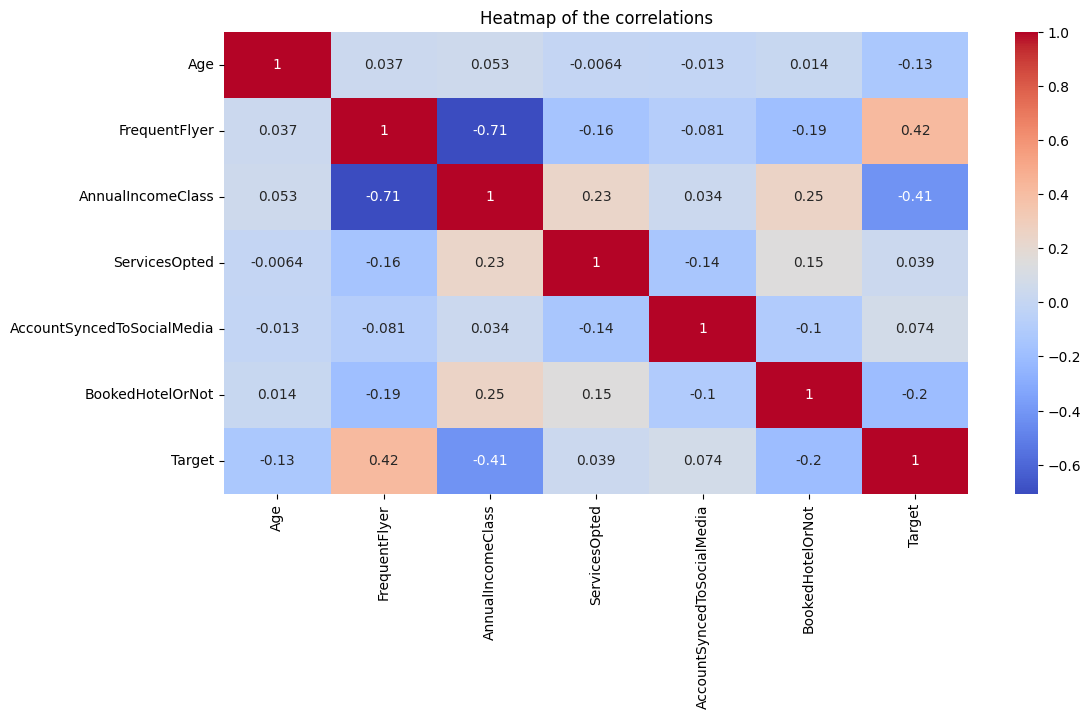

In [44]:
# Question 15: Plot heatmap of correlations

corr = df_travel.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Heatmap of the correlations')
plt.show()

Now, let's separate the dataset into features (X) and labels (y). Then, split the data into train and test sets using `train_test_split` function from Sklearn with `test_size=0.2`, `random_state=42`, and set `stratify=y` to preserve the label distribution in both sets.

In [45]:
# Seperate the dataset into features and labels

X = df_travel.drop(columns=['Target'])
y = df_travel[['Target']]

In [46]:
# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Before building any model, it's useful to establish a simple reference point. Imagine predicting the most frequent class for every single observation—no learning, just repetition. The accuracy you'd get from that naive approach is called the baseline accuracy. It’s the minimum benchmark any meaningful model should aim to outperform.

In [47]:
# Question 16: Calculate baseline accuracy

# TODO: Your code here

Now, let's standardize the features using `StandardScaler` from Sklearn.

In [48]:
# Standardise features

scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Exercise 2: Logistic regression

First, try use logistic regression for use our data. Use LogisticRegression with the following setting:
`penalty='l2', solver='lbfgs', max_iter=1000, random_state=30`

In [98]:
# Logistic Regression

model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=30)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=30)

In [99]:
# Question 17: Find the test accuracy

accuracy = model.score(X_test, y_test)
print(f"The model has an accuracy of {accuracy * 100:.4f}%")

The model has an accuracy of 85.4167%


Next, train a logistic regression classifier with cross-validation. Use 5 folds and 9 values in the logscale between $10^{-4}$ and $10^4$ for the regularizer parameter. For the rest of the arguments, we use the same values as we used for the logistic regression with no cross validation.

__Important:__ Set the following values for the arguments:
`
penalty='l2', solver='lbfgs', max_iter=1000, random_state=42, cv=4, Cs=*9*
`

In [96]:
# Train a logistic regression classifier with cross-validation

model = LogisticRegressionCV(penalty='l2', solver='lbfgs', max_iter=1000, random_state=42, cv=5, Cs=9)
model.fit(X_train, y_train)

LogisticRegressionCV(Cs=9, cv=5, max_iter=1000, random_state=42)

In [97]:
# Question 18: Find the value of the regularization parameter and the test accuracy

accuracy = model.score(X_test, y_test)
print(f"The value of the regularization parameter is {model.C_[0]}")
print(f"The model has an accuracy of {accuracy * 100:.4f}%")

The value of the regularization parameter is 1.0
The model has an accuracy of 85.4167%


## Exercise 3: KNN classifier

Use the KNeighborClassifier from sklearn using the following setting:
`n_neighbors=7, p=2, weights='uniform', algorithm="kd_tree"`

In [101]:
# KNeighborClassifier

model = KNeighborsClassifier(n_neighbors=7, p=2, weights='uniform', algorithm='kd_tree')

Use `GridSearchCV` to find the best hyper-parameters for your KNN model. Use values between 1 and 10 for `n_neighbors` argument and use either 'uniform' or 'distance' for the `weights` argument. Use a 5-fold cross validation. This translate to the following values for the arguments of the `GridSearchCV`:
```
param_grid={"n_neighbors": range(1, 11), "weights":["uniform", "distance"]}, cv=5
```

In [106]:
# Question 19: Find the accuracy of the best KNN model

kNN = GridSearchCV(model, param_grid={"n_neighbors": range(1, 11), "weights":["uniform", "distance"]}, cv=5)
kNN.fit(X_train, y_train)
print(f"The accuracy of the best KNN model is {kNN.best_score_ * 100:.4f}%")

The accuracy of the best KNN model is 88.6673%


In [108]:
# Question 20: Find the 'n_neighbors' and 'weights' values for the best KNN model
best_params = kNN.best_params_
n_neighbors = best_params['n_neighbors']
weights = best_params['weights']
print(f"The best KNN model had {n_neighbors} neighbors and used {weights} weights")

The best KNN model had 5 neighbors and used distance weights


## Exercise 4: Decision Tree

Train a Decision Tree classifier on the training data. Use the following values for the arguments of the decision tree:
```
criterion="gini", max_depth=3, random_state=30
```

In [109]:
# Decision Tree

model = DecisionTreeClassifier(criterion="gini", max_depth=3, random_state=30)

DecisionTreeClassifier(max_depth=3, random_state=30)

Use `GridSearchCV` to find the best hyper-parameters for your decision tree model. Use values between 1 and 7 for `max_depth` argument and use either 'gini' or 'entropy' for the `criterion` argument. Use a 5-fold cross validation. This translate to the following values for the arguments of the `GridSearchCV`:
```
param_grid={"max_depth": range(1, 8), "criterion":["gini", "entropy"]}, cv=5
```

In [111]:
# Question 21: Find the accuracy of the best decision tree model

DT = GridSearchCV(model, param_grid={"max_depth": range(1, 8), "criterion":["gini", "entropy"]}, cv=5)
DT.fit(X_train, y_train)
print(f"The accuracy of the best KNN model is {DT.best_score_ * 100:.4f}%")

The accuracy of the best KNN model is 88.7955%


In [113]:
# Question 22: Find the 'criterion' and 'max_depth' values for the best decision tree model

best_params = DT.best_params_
criterion = best_params['criterion']
max_depth = best_params['max_depth']
print(f"The best KNN model had a max depth of {max_depth} and used {criterion} criterion")

The best KNN model had a max depth of 6 and used gini criterion


The company places a strong emphasis on keeping its customers and has solid resources dedicated to retention. In such a case, choosing the right evaluation metric becomes crucial. The answer lies in understanding what matters most in this context.


Question 23: Find the best metric for the company

> As we want to miss the less churner as possible and it is not a big problem to have false positive. Recall is the best evaluations metric in this context.

In [59]:
# Question 24: Find the model that gives the best result using the metric above

